<a href="https://colab.research.google.com/github/ArturGrigo/ArturGrigo/blob/main/%D0%A2%D0%B5%D1%81%D1%82%D0%BE%D0%B2%D0%BE%D0%B5_%D0%B7%D0%B0%D0%B4%D0%B0%D0%BD%D0%B8%D0%B5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd # для таблиц
import seaborn as sns # для графиков
from sklearn.ensemble import RandomForestClassifier

In [3]:
df = pd.read_csv('/content/Maternal Health Risk Data Set.csv')



In [4]:
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,high risk
1,35,140,90,13.0,98.0,70,high risk
2,29,90,70,8.0,100.0,80,high risk
3,30,140,85,7.0,98.0,70,high risk
4,35,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


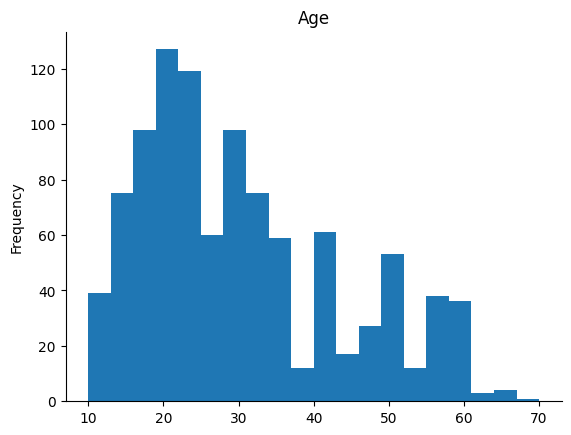

In [5]:
# @title Age

from matplotlib import pyplot as plt
df['Age'].plot(kind='hist', bins=20, title='Age')
plt.gca().spines[['top', 'right',]].set_visible(False)

## Опишем признаки которыми располагает таблица:

**SystolicBP** *Верхнее число — систолическое артериальное давление, показывает давление в артериях в момент, когда сердце сжимается и выталкивает кровь в артерии, оно зависит от силы сокращения сердца, сопротивления, которое оказывают стенки кровеносных сосудов, и числа сокращений в единицу времени.

**DiastolicBP** *Нижнее число — диастолическое артериальное давление, показывает давление в артериях в момент расслабления сердечной мышцы.

**BS** - уровень глюкозы в крови

**BodyTemp** - температура тела **(сразу обратим внимание что она определена в фаренгейтах)**

**HeartRate** -  нормальная частота пульса в состоянии покоя в ударах в минуту.

**RiskLevel**  - Уровень риска: прогнозируемый уровень интенсивности риска во время беременности с учетом предыдущего признака.


*Курсив*